In the context of deep learning and machine learning, a tensor is a fundamental data structure that represents multi-dimensional arrays. Tensors can be scalars (single numbers), vectors (1D arrays), matrices (2D arrays), or have more dimensions. Tensors are a generalization of matrices to higher dimensions and are a key building block for representing data in neural networks.

Here are some common terms related to tensors:

- Scalar: A scalar is a single number, e.g., a float or an integer.
- Vector: A vector is an ordered array of numbers. It can be considered as a 1D tensor.
- Matrix: A matrix is a 2D array of numbers. It can be considered as a 2D tensor.
- Tensor: A tensor is a generalization of a matrix to higher dimensions. It can be a 3D, 4D, or higher-dimensional array. Tensors are the basic building blocks for representing data in deep learning frameworks like PyTorch and TensorFlow.

In the context of neural networks, tensors are used to represent input data, model parameters, intermediate activations, and outputs. Operations on tensors, such as addition, multiplication, and other mathematical operations, are the foundation of neural network computations.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

Here are all the necessary libraries

In [2]:
# PyTorch is a popular deep learning library. It provides tensors, which are multi-dimensional arrays, and tools for building and training neural networks.
import torch

# This is an extension of PyTorch designed for computer vision tasks. It includes pre-trained models, datasets, and image transformation functions.
import torchvision

# Submodules from torchvision that provide access to standard datasets and pre-trained models for image-related tasks.
from torchvision import datasets, models

# This submodule provides functional image transformations. Functions in FT can be applied to images, like resizing or converting to tensors
from torchvision.transforms import functional as FT

# This submodule contains a set of functions for image transformations, such as data augmentation, normalization, and more.
from torchvision import transforms as T

# These modules provide tools for defining and training neural networks. nn is for building models, and optim is for optimization algorithms like stochastic gradient descent (SGD).
from torch import nn, optim

#  This submodule in torch.nn provides additional functions often used in neural network layers.
from torch.nn import functional as F

#  These are utility modules from torch.utils.data for handling data loading, splitting datasets, and creating custom datasets.
from torch.utils.data import DataLoader, sampler, random_split, Dataset

# The copy module provides functions for creating copies of objects in Python.
import copy

# The math module provides mathematical functions.
import math

#  The PIL module stands for the Python Imaging Library. It is a powerful library for opening, manipulating, and saving many different image file formats.
from PIL import Image

# OpenCV is a popular computer vision library. The cv2 module provides functions for image and video processing.
import cv2

# Albumentations is a library for advanced data augmentations. It's commonly used in computer vision tasks.
import albumentations as A  # our data augmentation library

# OpenCV is a popular computer vision library. The cv2 module provides functions for image and video processing.
import matplotlib.pyplot as plt
# This is an IPython magic command. When used in a Jupyter notebook, it ensures that Matplotlib plots are displayed directly below code cells.
%matplotlib inline

In [3]:
# remove warnings (optional)
import warnings
warnings.filterwarnings("ignore")

# Collections module for defaultdict and deque
from collections import defaultdict, deque

# Module for working with dates and times
import datetime

# Module for introducing delays in the code
import time

# tqdm for displaying progress bars in the console
from tqdm import tqdm

# torchvision.utils submodule for drawing bounding boxes on images
from torchvision.utils import draw_bounding_boxes

In [4]:
# Printing the version of Pytorch
print("PyTorch version:", torch.__version__)
# Printing the version of Torchvision
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.1.2+cpu
Torchvision version: 0.16.2+cpu


PyCOCOTools provides many utilities for dealing with datasets in the COCO format, and if you want, you could evaluate the model's performance on the dataset with some of the utilities provided with this library.

That is out of scope for this notebook, however.

 This module provides an implementation of the COCO (Common Objects in Context) API, which is a set of tools for working with the COCO dataset. The COCO dataset is a widely used benchmark for object detection, segmentation, and captioning tasks.

In [5]:
# our dataset is in cocoformat, we will need pypcoco tools
from pycocotools.coco import COCO

In [6]:
# Now, we will define our transforms
# ToTensorV2 class is a transformation that converts images and masks to PyTorch tensors. This is useful when working with PyTorch-based deep learning models, as they typically expect input data in the form of tensors.
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [7]:
#  This function returns an image augmentation pipeline based on whether it is for training or not.
def get_transforms(train=False):
    # If True, the function returns a pipeline suitable for training data
    if train:
        # Albumentations class for creating a composition of augmentation transformations.
        transform = A.Compose([
            # Resize the input image to the specified dimensions.
            A.Resize(600, 600), # our input size can be 600px
            # Apply horizontal and vertical flips with specified probabilities.
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            # Apply random changes to brightness and contrast with a specified probability.
            A.RandomBrightnessContrast(p=0.1),
            # Apply color jittering with a specified probability.
            A.ColorJitter(p=0.1),
            # Convert the image to a PyTorch tensor.
            ToTensorV2()
            # Specify bounding box parameters, including the format of bounding box annotations (in COCO format in this case).
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        # If train is False, it returns a pipeline for validation/test data.
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

For training images, the get_transforms function applies a series of augmentation techniques, including resizing, horizontal and vertical flips, random brightness and contrast adjustments, color jittering, and finally, it converts the augmented image to a PyTorch tensor.

For validation or test images, it keeps the resizing operation to maintain consistency with the training images, but it skips other augmentations that are typically applied during training. It also converts the image to a PyTorch tensor.

### Dataset
This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [8]:

class HelmetDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # Initialization method for the dataset
        # Parameters:
        #   - root: Root directory of the dataset
        #   - split: Dataset split (train, valid, test)
        #   - transform: Applies transformations to the input images. The image transformation to be applied. It could be a single transformation or a composition of multiple transformations. Default is set to None.
        #   - target_transform: Applies transformations to the target annotations (e.g., bounding boxes, segmentation masks)
        #   - transforms: An additional set of transformations. This is different from transform and target_transform and can be used for more complex scenarios. Default is set to None.
        
        #   The 3 transform parameters are required for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        
        # Dataset split (train, valid, test)
        # "split": Specifies whether it's for training, validation, or testing (default is 'train').
        self.split = split
        
        # COCO object to load annotations
        # In summary, this line is responsible for creating a COCO object that will be used to load and work with annotations from the specified COCO dataset split.
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) 
        
        # List of image IDs with non-empty annotations
        # It creates a list of image IDs by extracting them from the imgs attribute of the COCO object. These IDs are then sorted in ascending order. The resulting list (self.ids) contains the identifiers of all images in the specified COCO dataset split.
        self.ids = list(sorted(self.coco.imgs.keys()))
        # It filters the list of image IDs by checking whether each image has associated targets or annotations. The _load_target method is used to load the annotations for a given image ID (id). If the length of the annotations is greater than 0 (i.e., there are annotations present), the image ID is kept in the list; otherwise, it is removed.
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        # Get the file name of the image using the COCO API
        path = self.coco.loadImgs(id)[0]['file_name']
        
        # Read the image using OpenCV, and convert the color format from BGR to RGB
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Return the loaded and formatted image
        return image
    
    # def _load_target(self, id):
    #     # Load and return annotations for the image with the given ID
    #     return self.coco.loadAnns(self.coco.getAnnIds(id))

    def _load_target(self, id):
        # Use COCO API to get the annotation IDs associated with the image ID
        annotation_ids = self.coco.getAnnIds(id)
        
        # Load annotations using the obtained annotation IDs
        annotations = self.coco.loadAnns(annotation_ids)
        
        # Return the loaded annotations for the image
        return annotations
    
    def __getitem__(self, index):
        # Method to get a sample from the dataset
        id = self.ids[index]
        
        # Load image and annotations
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        # # Extract bounding boxes from annotations and concatenate with category IDs
        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        # Extract transformed image and bounding boxes
        image = transformed['image']
        boxes = transformed['bboxes']
        
        # Convert bounding box coordinates from xywh to xyxy
        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        # Convert bounding boxes to PyTorch tensor
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        # Create a dictionary containing transformed target information
        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        
        # Scale images by dividing by 255
        return image.div(255), targ
    
    def __len__(self):
        # Method to get the length of the dataset
        return len(self.ids)

In [9]:
dataset_path = r"C:\Users\user\My ML Projects\Helmet Prediction\data"

In [10]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


{0: {'id': 0, 'name': 'rider-helmet-bike', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'With Helmet', 'supercategory': 'rider-helmet-bike'},
 2: {'id': 2, 'name': 'Without Helmet', 'supercategory': 'rider-helmet-bike'}}

This code just gets a list of classes

In [14]:
# Display information about all images
for img_id in coco.imgs.keys():
    img_info = coco.loadImgs(img_id)[0]
    print(f"Image ID: {img_info['id']}, File Name: {img_info['file_name']}")
    
    # Display annotations for the image
    ann_ids = coco.getAnnIds(img_id)
    annotations = coco.loadAnns(ann_ids)
    for annotation in annotations:
        print(f"  Annotation ID: {annotation['id']}, Category: {coco.cats[annotation['category_id']]['name']}, Bbox: {annotation['bbox']}")

    print("=" * 50)

Image ID: 0, File Name: BikesHelmets605_png_jpg.rf.62b28e9a26ac0d500429684cf128901d.jpg
  Annotation ID: 0, Category: Without Helmet, Bbox: [70, 57, 38, 64]
  Annotation ID: 1, Category: Without Helmet, Bbox: [100, 60, 36, 69.5]
  Annotation ID: 2, Category: Without Helmet, Bbox: [130, 68, 26.5, 54]
  Annotation ID: 3, Category: Without Helmet, Bbox: [153, 66, 33, 58]
  Annotation ID: 4, Category: Without Helmet, Bbox: [198, 6, 37, 72]
  Annotation ID: 5, Category: Without Helmet, Bbox: [230, 54, 36, 53.5]
  Annotation ID: 6, Category: Without Helmet, Bbox: [264, 44, 34.5, 55]
Image ID: 1, File Name: BikesHelmets47_png_jpg.rf.634dcbfa30743b07445b07deefb155d7.jpg
  Annotation ID: 7, Category: Without Helmet, Bbox: [361, 137, 26, 41]
  Annotation ID: 8, Category: Without Helmet, Bbox: [261, 137, 33, 57]
  Annotation ID: 9, Category: Without Helmet, Bbox: [63, 133, 41, 66]
  Annotation ID: 10, Category: Without Helmet, Bbox: [178, 143, 35, 54]
Image ID: 2, File Name: BikesHelmets372_png_j

In [15]:
classes = [i[1]['name'] for i in categories.items()]
classes

['rider-helmet-bike', 'With Helmet', 'Without Helmet']

In [16]:
len(classes)

3

In [17]:
train_dataset = HelmetDetection(root=dataset_path, transforms=get_transforms(train=True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

In [20]:
train_dataset[2]

(tensor([[[0.8824, 0.8824, 0.8824,  ..., 0.9294, 0.9294, 0.9294],
          [0.8824, 0.8824, 0.8824,  ..., 0.9333, 0.9333, 0.9294],
          [0.8824, 0.8824, 0.8824,  ..., 0.9373, 0.9373, 0.9333],
          ...,
          [0.8157, 0.8235, 0.8275,  ..., 0.6000, 0.5922, 0.5882],
          [0.8353, 0.8392, 0.8431,  ..., 0.5882, 0.5804, 0.5765],
          [0.8431, 0.8431, 0.8471,  ..., 0.5804, 0.5725, 0.5647]],
 
         [[0.8863, 0.8863, 0.8863,  ..., 0.9294, 0.9294, 0.9294],
          [0.8863, 0.8863, 0.8863,  ..., 0.9333, 0.9333, 0.9294],
          [0.8863, 0.8863, 0.8863,  ..., 0.9373, 0.9373, 0.9333],
          ...,
          [0.6039, 0.6039, 0.6039,  ..., 0.6235, 0.6196, 0.6157],
          [0.6235, 0.6235, 0.6235,  ..., 0.6196, 0.6118, 0.6078],
          [0.6314, 0.6314, 0.6353,  ..., 0.6157, 0.6118, 0.6078]],
 
         [[0.8941, 0.8941, 0.8941,  ..., 0.9294, 0.9294, 0.9294],
          [0.8941, 0.8941, 0.8941,  ..., 0.9333, 0.9333, 0.9294],
          [0.8941, 0.8941, 0.8941,  ...,

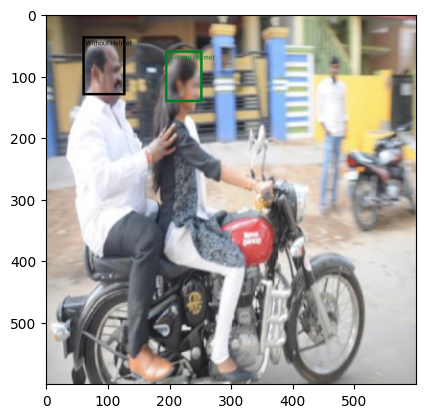

In [21]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [22]:
len(train_dataset)

1182

### Model
Our model is FasterRCNN with a backbone of MobileNetV3-Large. We need to change the output layers because we have just 6 classes but this model was trained on 90 classes.

In [23]:
# lets load the faster rcnn model from the pytorch models module
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

- model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True):
This line loads a pre-trained Faster R-CNN model with a MobileNetV3-Large backbone. The pretrained=True argument indicates that the model should use pre-trained weights.

- in_features = model.roi_heads.box_predictor.cls_score.in_features:
It retrieves the number of input features of the classification layer (cls_score) in the model's region of interest (ROI) heads. This information is needed for creating a new classification layer.

- model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes):
It replaces the existing box predictor in the model's ROI heads with a new FastRCNNPredictor that has the correct number of output classes (n_classes). This step is necessary because the original model might have been trained on a dataset with a different number of classes, and you need to adapt it to your specific task.

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [25]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

The collate_fn takes a list of samples (each sample being a tuple of image and target) and transposes them, resulting in a tuple of lists where the first list contains all the images in the batch, and the second list contains all the targets.

In [26]:
import os
import sys
import dill

def save_object(file_path: str, obj: object) -> None:
    logging.info("Entered the save_object method of utils")

    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, "wb") as file_obj:
        dill.dump(obj, file_obj)

    logging.info("Exited the save_object method of utils")



def load_object(file_path: str) -> object:
    logging.info("Entered the load_object method of utils")


    with open(file_path, "rb") as file_obj:
        obj = dill.load(file_obj)

    logging.info("Exited the load_object method of utils")

    return obj


The following blocks ensures that the model can take in the data and that it will not crash during training

In [27]:
# Fetch a batch from the training loader
images, targets = next(iter(train_loader))
# Convert the images to a list
images = list(image for image in images)
# Convert the targets to a list of dictionaries with the required format
targets = [{k: v for k, v in t.items()} for t in targets]
# Pass the images and targets through the model to ensure it runs without errors
output = model(images, targets)

In [ ]:
# Check if CUDA (GPU support for PyTorch) is available
use_cuda = torch.cuda.is_available()

# Set the device to CUDA (GPU) if available, otherwise use CPU
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# Move the PyTorch model to the specified device (GPU or CPU)
model = model.to(device)

## Optimizer

Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
import sys

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    # Move the model to the specified device
    model.to(device)
    # Set the model to training mode
    model.train()
    
    # Uncomment the following block if you want to use a learning rate scheduler
    # lr_scheduler = None
    # if epoch == 0:
    #     warmup_factor = 1.0 / 1000  # do lr warmup
    #     warmup_iters = min(1000, len(loader) - 1)
    #     lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)
    
    # Lists to store loss values and their components
    all_losses = []
    all_losses_dict = []
    
    # Iterate over the data loader
    for images, targets in tqdm(loader):
        # Move images to the specified device
        images = [image.to(device) for image in images]
        # Move targets to the specified device
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass: Compute the loss
        loss_dict = model(images, targets)
        # Sum all individual losses
        losses = sum(loss for loss in loss_dict.values())
        
        # Convert loss dictionary to a format suitable for logging
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        # Extract the overall loss value
        loss_value = losses.item()
        
        # Append the overall loss and loss dictionary to the lists
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        # Check for finite loss; stop training if loss becomes infinite
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)
        
        # Backward pass: Zero gradients, compute gradients, and update model parameters
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Uncomment the following block if you want to use the learning rate scheduler
        # if lr_scheduler is not None:
        #     lr_scheduler.step()  # Update learning rate
        
    # Convert the list of dictionaries to a pandas DataFrame for printing
    all_losses_dict = pd.DataFrame(all_losses_dict)
    
    # Print training statistics at the end of each epoch
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [ ]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

In [ ]:
# our learning rate was too low, due to a lr scheduler bug. For this task, we wont need a scheudul.er

## Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [ ]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [35]:
test_dataset = HelmetDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [37]:
len(test_dataset)

63

In [22]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

AssertionError: targets should not be none when in training mode

In [ ]:
prediction

In [ ]:
# it did learn

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

### Prediction

In [14]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda") # use GPU to train

classes = ['vehicles', 'Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

model = torch.load(r"D:\Project\DL\torch-object-detection\artifacts\11_12_2022_14_58_46\TrainedModel\model.pt")

model.eval()

img = Image.open(r"D:\Project\DL\torch-object-detection\artifacts\11_12_2022_14_58_46\DataIngestionArtifacts\train\0a03d85b3dcb2a1b_jpg.rf.a00ac9c0b1e0178bd393f049593c73c6.jpg")

convert_tensor = transforms.ToTensor()

img1 = convert_tensor(img)

img_int = torch.tensor(img1*255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([img1.to(device)])
    pred = prediction[0]

bbox_tensor = draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(0, 2, 1)

In [15]:
bbox_tensor

tensor([[[182, 183, 184,  ...,   0,   0,   0],
         [177, 178, 179,  ...,   0,   0,   0],
         [180, 181, 182,  ...,   0,   0,   0],
         ...,
         [160, 159, 247,  ...,  95, 101, 104],
         [216, 201, 255,  ...,  93, 103, 108],
         [225, 202, 253,  ...,  94, 104, 109]],

        [[190, 191, 192,  ...,   0,   0,   0],
         [185, 186, 187,  ...,   0,   0,   0],
         [188, 189, 190,  ...,   0,   0,   0],
         ...,
         [135, 136, 228,  ...,  26,  20,  17],
         [193, 180, 246,  ...,  27,  20,  16],
         [204, 183, 238,  ...,  28,  20,  17]],

        [[175, 176, 177,  ...,   0,   0,   0],
         [170, 171, 172,  ...,   0,   0,   0],
         [177, 178, 179,  ...,   0,   0,   0],
         ...,
         [141, 142, 232,  ...,  29,  27,  26],
         [199, 185, 249,  ...,  31,  30,  31],
         [209, 187, 241,  ...,  32,  33,  32]]], dtype=torch.uint8)

In [21]:
transform = transforms.ToPILImage()

img = transform(bbox_tensor)

type(img)

PIL.Image.Image

In [22]:
# Converting image into base64

import base64
from io import BytesIO

buffered = BytesIO()
img.save(buffered, format="JPEG")
img_str = base64.b64encode(buffered.getvalue())

In [23]:
img_str

b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAGgAaADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDpo9UnHVE/75arA1hlA3IOfr/hU6Qvjkx/98f/AF6jVGlmY4TrsB2+nWqdJGXMYeuRR3+253JCyDGWbgg/XFcyG2yYPPuK9ONrvjKPFEykYIPeuA8VCDSru0t4IA0k7n5Vb7qj/wCvVJchy16PtNY7/mMt3GcUSKFnYcgH5i

In [38]:
import pandas as pd

In [39]:
data = pd.read_csv(r"D:\Project\DL\helmet-detection-pytorch\artifacts\11_16_2022_12_41_54\ModelEvaluationArtifacts\loss.csv")

In [40]:
data.head()

,loss_classifier,loss_box_reg,loss_objectness,loss_rpn_box_reg
0,0.372708,0.518290,0.005458,0.006385
1,0.292473,0.345040,0.002057,0.005221
2,0.627907,0.612128,0.003006,0.004052
3,0.442698,1.046861,0.000452,0.003719
4,0.267509,0.519895,0.006574,0.003500


In [45]:
data.describe()

,loss_classifier,loss_box_reg,loss_objectness,loss_rpn_box_reg
count,63.000000,63.000000,63.000000,63.000000
mean,0.334492,0.394878,0.011079,0.009204
std,0.176800,0.233789,0.009858,0.008282
min,0.031824,0.013911,0.000452,0.000537
25%,0.231558,0.213059,0.003231,0.002868
50%,0.312758,0.345040,0.006970,0.006372
75%,0.384861,0.527461,0.017669,0.014127
max,0.945624,1.086539,0.034559,0.034723


In [44]:
data.describe().mean()

loss_classifier     8.177240
loss_box_reg        8.226835
loss_objectness     7.885477
loss_rpn_box_reg    7.884514
dtype: float64

<AxesSubplot: >

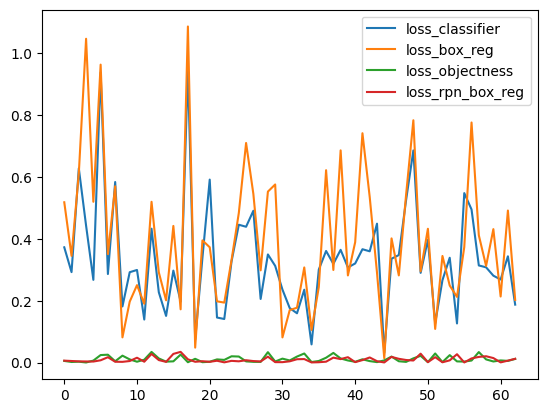

In [46]:
data.plot()

In [48]:
model = torch.load(r"D:\Project\DL\helmet-detection-pytorch\artifacts\PredictModel\model.pt")

In [49]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [50]:
model.parameters

<bound method Module.parameters of FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2):

In [54]:
model.

<bound method Module.state_dict of FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2):